In [10]:
import json 

def load_questions(activation_f, question_f, max_size = -1):
    activations_file = "/Users/daniel/ideaProjects/allennlp_invariances/" + activation_f
    questions_file = "/Users/daniel/ideaProjects/allennlp_invariances/" + question_f
    features = []
    pred_ans = []
    with open(activations_file) as f:
        content = f.read().splitlines()
        for i, l in enumerate(content):
            # print(i)
            # print(l[0:100])

            if (max_size > -1 and len(pred_ans) > max_size):
                break

            if i % 2 == 0:
                # print(l)
                data = json.loads(l)
                features.append(data)
            else:
                pred_ans.append(l)

    questions = []
    labels = []
    with open(questions_file) as f:
        content = f.read().splitlines()
        for i, l in enumerate(content):
#             print(i)
#             print(l[0:100])
            if i % 3 == 0:
                questions.append({})
                questions[int(i / 3)]["q"] = l
            elif i % 3 == 1:
                questions[int(i / 3)]["p"] = l
            elif i % 3 == 2:
                ans = json.loads(l)
                questions[int(i / 3)]["a"] = [c['text'] for c in ans]
                labels.append(ans[0]['text'])

            if (max_size > -1 and len(labels) > max_size):
                break
    mat = numpy.array(features)

    return (mat, labels, questions, pred_ans)

In [11]:
from prereq import Prerequisit_Skills

preq = Prerequisit_Skills()
# print(preq.skills_map)
prerequisits = preq.read_prereq_file("squad.json")

# ignore the nonsense content 
prerequisits = {x: prerequisits[x]  for x in prerequisits.keys() if 'Nonsense' not in prerequisits[x] }
# print(len(prerequisits))
# print(set(prerequisits.keys()))
# print(len(set(prerequisits.keys())))
prerequisits, len(prerequisits)

({'57309921396df919000961f8-1': ['Bridging', 'Elaboration', 'Coreference'],
  '5730cc2cb54a4f140068cc68-1': ['Coreference'],
  '5730d523aca1c71400fe5b03-1': ['No skill'],
  '5730d77ef6cb411900e244de-1': ['No skill'],
  '5730b2312461fd1900a9cfaf-1': ['Bridging'],
  '5730b9852461fd1900a9cff9-1': ['Bridging'],
  '5730b10b8ab72b1400f9c69e-1': ['Bridging',
   'Elaboration',
   'Schematic clauses',
   'Punctuation'],
  '5730d77ef6cb411900e244dc-1': ['Schematic clauses'],
  '5730a97a396df9190009625c-1': ['Bridging',
   'Coreference',
   'Schematic clauses',
   'Punctuation'],
  '5730c52fb54a4f140068cc46-1': ['No skill'],
  '57309d31396df91900096213-1': ['Spatio-temporal'],
  '5726e1fcdd62a815002e93c7-1': ['Elaboration'],
  '5726a0205951b619008f781d-1': ['Schematic clauses', 'Punctuation'],
  '5726cc11dd62a815002e9089-1': ['No skill'],
  '5726e680dd62a815002e9470-1': ['No skill'],
  '5726d4a45951b619008f7f69-1': ['Object  Tracking', 'Schematic clauses'],
  '5726f1ec708984140094d6a9-1': ['No sk

In [12]:
# extrat dev questions based on prerequesti keys 
question_paragraph_id_map = {}

paragraphs = []
dataset_file = "/Users/daniel/ideaProjects/linear-classifier/other/questionSets/squad-dev-v1.1.json"
with open(dataset_file) as file:
    dataset_json = json.load(file)
    dataset = dataset_json['data']
    for aid, article in enumerate(dataset):
        for pid, paragraph in enumerate(article['paragraphs']):
            context = paragraph['context']
            qas = []
            for qa in paragraph['qas']:
                qid = qa["id"] + "-1"
                if qid in prerequisits: 
                    qas.append(qa)
            if len(qas) > 0: 
                paragraphs.append({"context": context, "qas": qas})

data_json = {"data": [{"paragraphs": paragraphs}]}
with open('/Users/daniel/ideaProjects/allennlp_invariances/QA_datasets/squad-dev-v1.1-with-prereq-annotations.json', 'w', newline='') as f:
    f.write(json.dumps(data_json))

In [13]:
# read the questions and remember question ids:
question_paragraph_id_map = {}

dataset_file = "/Users/daniel/ideaProjects/allennlp_invariances/QA_datasets/squad-dev-v1.1-with-prereq-annotations.json"
with open(dataset_file) as file:
    dataset_json = json.load(file)
    dataset = dataset_json['data']
    for aid, article in enumerate(dataset):
        new_paragraphs = []
        for pid, paragraph in enumerate(article['paragraphs']):
            context = paragraph['context']
            for qa in paragraph['qas']:
                qid = qa["id"] + "-1"
                if qid in prerequisits: 
                    key = qa['question']
                    question_paragraph_id_map[key] = qid
len(question_paragraph_id_map)

96

In [14]:
import json
import numpy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

(mat, labels, questions, pred_ans) = load_questions("ipython/squad_dev_with_prereq/out33-ner-test.txt", "ipython/squad_dev_with_prereq/out22-ner-test.txt", max_size=-1)
# (mat_ad, labels_ad, questions_ad, pred_ans_ad) = load_questions("ipython/babi/out33-adv.txt", "ipython/babi/out22-adv.txt", max_size=-1)

assert len(mat) == len(question_paragraph_id_map)


In [15]:
multirc_reasoning_types = []
for i, x in enumerate(questions): 
    key = x['q']
#     print(key)
    idd = question_paragraph_id_map[key]
    multirc_reasoning_types.append(prerequisits[idd])

bibi_reasoning_types = multirc_reasoning_types
    
len(multirc_reasoning_types), len(questions)

(96, 96)

In [16]:
from evaluate11 import metric_max_over_ground_truths, f1_score, exact_match_score

# find the quality per reasoning type
scores = []
unique_types111 = set([y for x in multirc_reasoning_types for y in x])
# print(unique_types111)

assert len(pred_ans) == len(questions)

scores_zipped_labels= []
for t in unique_types111:
    scores_ins = []
    # select questions which contain the reasoning type 
    for i, x  in enumerate(questions): 
        question = x["q"]
#         print(i)
#         (ans_text, correct_or_not, phenomenon_labels) = info_map[question]
#         assert sum(correct_or_not) > 0
        if t in multirc_reasoning_types[i]: # check if the target phenomena is included 
            correct_ans = x["a"]
            predicted_label = pred_ans[i]
            max_f1 = max([f1_score(predicted_label,y) for y in correct_ans])
            scores_ins.append(100.0 * max_f1)
    scores_zipped_labels.append((sum(scores_ins) / len(scores_ins), t))
    print(str(t) + " -> " + str(sum(scores_ins) / len(scores_ins)), len(scores))

# scores_zipped_labels

# unique_types111, multirc_reasoning_types

Punctuation -> 76.8859160163508 0
Bridging -> 73.34697146137293 0
Elaboration -> 85.60794044665013 0
Object  Tracking -> 66.66666666666667 0
No skill -> 90.25641025641025 0
Schematic clauses -> 75.3642749860244 0
Spatio-temporal -> 100.0 0
Ellipsis (implicit info) -> 69.50354609929077 0
Coreference -> 81.26045400238948 0


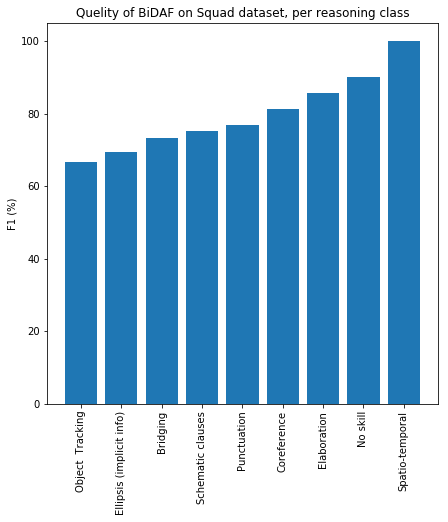

In [17]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['axes.unicode_minus'] = False
fig, ax = plt.subplots(figsize=(7, 7))

# scores_zipped_labels = list(zip(scores,unique_types111))
scores_zipped_labels.sort(key=lambda x: x[0])
scores22, unique_types22 = zip(*scores_zipped_labels)

plt.bar(range(len(scores22)), scores22)
# ax.plot(range(len(scores)), scores, 'o')
ax.set_ylabel('F1 (%)')
ax.set_title('Quelity of BiDAF on Squad dataset, per reasoning class')
# ax.set_yticks(range(len(q_labels)))
# ax.set_xticks(range(len(bibi_reasoning_types)))
ax.set_xticks(np.arange(len(unique_types22)))

# ax.set_yticklabels(q_labels)
ax.set_xticklabels(unique_types22, rotation=90)
plt.show()

In [9]:
# clustering points into two groups 
# (mat_ad, labels_ad, questions_ad, pred_ans_ad) = load_questions("ipython/squad_dev_with_prereq/out33-adv.txt", "ipython/squad_dev_with_prereq/out22-adv.txt", max_size=-1)

# # read the questions and remember question ids:
# question_paragraph_id_map = {}
# ff = "/Users/daniel/ideaProjects/allennlp/QA_datasets/babi-test.json"
# with open(ff) as file:
#     dataset_json = json.load(file)
#     dataset = dataset_json['data']
#     for article in dataset:
#         for paragraph in article['paragraphs']:
#             for qa in paragraph['qas']:
#                 key = qa['question'] + paragraph['context']
#                 question_paragraph_id_map[key] = qa['id']

# bibi_reasoning_types = [question_paragraph_id_map[x["q"]+x["p"]] for x in questions_ad]
# bibi_reasoning_types

In [18]:
unique_reasoning_types = list(set([y for x in bibi_reasoning_types for y in x]))

In [19]:
import numpy 

# bibi_reasoning_type_indices = [unique_reasoning_types.index(x) for x in bibi_reasoning_types]

ss = len(unique_reasoning_types)
accuracy_table = np.zeros(shape=(ss, ss)) 
count_table = np.empty(shape=(ss, ss), dtype=object) 

for ind1, type1 in enumerate(unique_reasoning_types): 
    for ind2, type2 in enumerate(unique_reasoning_types):
        
#         if ind1 > 3 or ind2 >3: 
#             continue 
        
        count1 = 0
        count2 = 0
    
        # we want different types 
        if type1 == type2 or ind2 <= ind1: 
            continue 
        print("type1: ", type1, " type2: ", type2)
        
        # loop through instances and select the points that have one of the two labels. 
        points = []
        labels = []
        for i, x in enumerate(bibi_reasoning_types): 
#             if type1 in x or type2 in x:
#                 points.append(mat[i])
#                 labels.append(x)
            
            if type1 in x and type2 not in x: 
                points.append(mat[i])
                labels.append(x)
                count1 += 1

            if type2 in x and type1 not in x : 
                points.append(mat[i])
                labels.append(x)
                count2 += 1
        
        from sklearn.cluster import KMeans
        print("len(points): ", len(points))
        # print("points: ", points)
        db = KMeans(n_clusters=2, random_state=2).fit(points)
        cluster_labels = db.labels_
        
        # calculate the confusion matrix 
        same_label_same_cluster = 0
        same_label_diff_cluster = 0
        diff_label_same_cluster = 0
        diff_label_diff_cluster = 0
        
        for ii in range(len(cluster_labels)):
            for jj in range(len(cluster_labels)):
                if ii == jj: 
                    continue 
                if cluster_labels[ii] == cluster_labels[jj] and labels[ii] == labels[jj]: 
                    same_label_same_cluster += 1
                if cluster_labels[ii] != cluster_labels[jj] and labels[ii] == labels[jj]: 
                    same_label_diff_cluster += 1
                if cluster_labels[ii] == cluster_labels[jj] and labels[ii] != labels[jj]: 
                    diff_label_same_cluster += 1
                if cluster_labels[ii] != cluster_labels[jj] and labels[ii] != labels[jj]: 
                    diff_label_diff_cluster += 1
        total_pairs = same_label_same_cluster + same_label_diff_cluster + diff_label_same_cluster + diff_label_diff_cluster
        print("same_label_same_cluster: ", same_label_same_cluster / total_pairs, same_label_same_cluster)
        print("same_label_diff_cluster: ", same_label_diff_cluster / total_pairs, same_label_diff_cluster)
        print("diff_label_same_cluster: ", diff_label_same_cluster / total_pairs, diff_label_same_cluster)
        print("diff_label_diff_cluster: ", diff_label_diff_cluster / total_pairs, diff_label_diff_cluster)
        print("---------")
        accuracy_table[ind1][ind2] = (diff_label_diff_cluster + same_label_same_cluster) / total_pairs
        accuracy_table[ind2][ind1] = accuracy_table[ind1][ind2] 
        
        countstr = str(f"{len(labels)}/{count1}/{count2}")
        print(countstr)
        count_table[ind1][ind2] = countstr
        count_table[ind2][ind1] = count_table[ind1][ind2] 
        
accuracy_table

type1:  Punctuation  type2:  Bridging
len(points):  34
same_label_same_cluster:  0.14616755793226383 164
same_label_diff_cluster:  0.06951871657754011 78
diff_label_same_cluster:  0.5543672014260249 622
diff_label_diff_cluster:  0.22994652406417113 258
---------
34/8/26
type1:  Punctuation  type2:  Elaboration
len(points):  32
same_label_same_cluster:  0.07661290322580645 76
same_label_diff_cluster:  0.034274193548387094 34
diff_label_same_cluster:  0.5362903225806451 532
diff_label_diff_cluster:  0.3528225806451613 350
---------
32/21/11
type1:  Punctuation  type2:  Object  Tracking
len(points):  22
same_label_same_cluster:  0.1341991341991342 62
same_label_diff_cluster:  0.05194805194805195 24
diff_label_same_cluster:  0.5541125541125541 256
diff_label_diff_cluster:  0.2597402597402597 120
---------
22/21/1
type1:  Punctuation  type2:  No skill
len(points):  50
same_label_same_cluster:  0.23673469387755103 580
same_label_diff_cluster:  0.08489795918367347 208
diff_label_same_cluster:

same_label_same_cluster:  0.055384615384615386 36
same_label_diff_cluster:  0.05846153846153846 38
diff_label_same_cluster:  0.4523076923076923 294
diff_label_diff_cluster:  0.4338461538461538 282
---------
26/25/1
type1:  Schematic clauses  type2:  Coreference
len(points):  27
same_label_same_cluster:  0.08262108262108261 58
same_label_diff_cluster:  0.008547008547008548 6
diff_label_same_cluster:  0.7122507122507122 500
diff_label_diff_cluster:  0.19658119658119658 138
---------
27/21/6
type1:  Spatio-temporal  type2:  Ellipsis (implicit info)
len(points):  5
same_label_same_cluster:  0.0 0
same_label_diff_cluster:  0.0 0
diff_label_same_cluster:  0.6 12
diff_label_diff_cluster:  0.4 8
---------
5/2/3
type1:  Spatio-temporal  type2:  Coreference
len(points):  14
same_label_same_cluster:  0.06593406593406594 12
same_label_diff_cluster:  0.01098901098901099 2
diff_label_same_cluster:  0.6703296703296703 122
diff_label_diff_cluster:  0.25274725274725274 46
---------
14/2/12
type1:  Elli

array([[0.        , 0.37611408, 0.42943548, 0.39393939, 0.42612245,
        0.50201613, 0.50333333, 0.32923077, 0.49802372],
       [0.37611408, 0.        , 0.34782609, 0.37630662, 0.39113257,
        0.35845411, 0.36766334, 0.39487179, 0.35462185],
       [0.42943548, 0.34782609, 0.        , 0.38461538, 0.54487179,
        0.36895161, 0.26666667, 0.34166667, 0.40441176],
       [0.39393939, 0.37630662, 0.38461538, 0.        , 0.66206897,
        0.47384615, 0.6       , 0.53333333, 0.44871795],
       [0.42612245, 0.39113257, 0.54487179, 0.66206897, 0.        ,
        0.33473096, 0.75123153, 0.66206897, 0.55870445],
       [0.50201613, 0.35845411, 0.36895161, 0.47384615, 0.33473096,
        0.        , 0.50997151, 0.48923077, 0.27920228],
       [0.50333333, 0.36766334, 0.26666667, 0.6       , 0.75123153,
        0.50997151, 0.        , 0.4       , 0.31868132],
       [0.32923077, 0.39487179, 0.34166667, 0.53333333, 0.66206897,
        0.48923077, 0.4       , 0.        , 0.2952381 ],


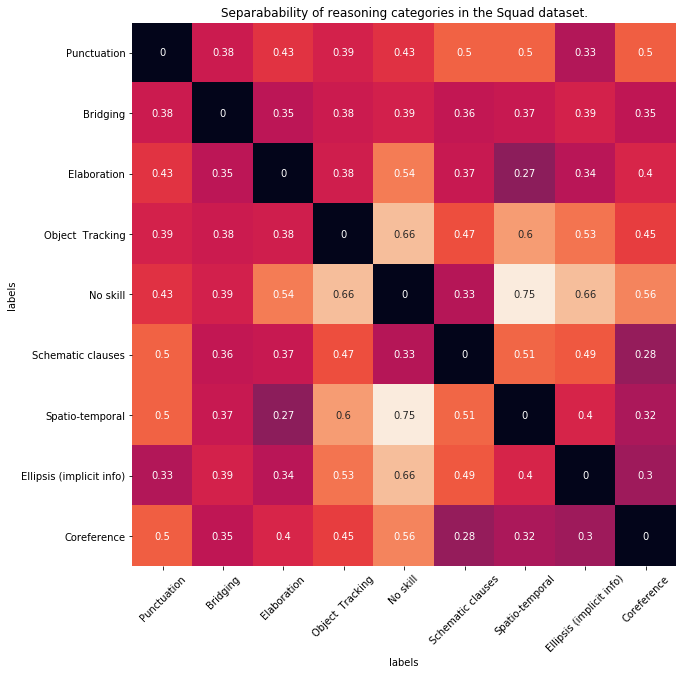

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import cluster, metrics

plt.figure(figsize=(10, 10))
sss = sns.heatmap(accuracy_table, square=True,
            annot=True,
            cbar=False,
            xticklabels=True,
            yticklabels=True
            )

sss.set_xticklabels(unique_reasoning_types, rotation=45)
sss.set_yticklabels(unique_reasoning_types, rotation=0)
plt.xlabel('labels')
plt.ylabel('labels')
plt.title('Separabability of reasoning categories in the Squad dataset.')
plt.show()

In [21]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in accuracy_table]))

0.0	0.3761140819964349	0.42943548387096775	0.3939393939393939	0.42612244897959184	0.5020161290322581	0.5033333333333333	0.3292307692307692	0.4980237154150198
0.3761140819964349	0.0	0.34782608695652173	0.37630662020905925	0.39113257243195787	0.35845410628019325	0.36766334440753046	0.39487179487179486	0.3546218487394958
0.42943548387096775	0.34782608695652173	0.0	0.38461538461538464	0.5448717948717948	0.3689516129032258	0.26666666666666666	0.3416666666666667	0.40441176470588236
0.3939393939393939	0.37630662020905925	0.38461538461538464	0.0	0.6620689655172414	0.47384615384615386	0.6	0.5333333333333333	0.44871794871794873
0.42612244897959184	0.39113257243195787	0.5448717948717948	0.6620689655172414	0.0	0.33473095737246683	0.7512315270935961	0.6620689655172414	0.5587044534412956
0.5020161290322581	0.35845410628019325	0.3689516129032258	0.47384615384615386	0.33473095737246683	0.0	0.50997150997151	0.48923076923076925	0.2792022792022792
0.5033333333333333	0.36766334440753046	0.2666666666666666

In [22]:
count_table[count_table == None] = ""
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in count_table]))
unique_reasoning_types

	34/8/26	32/21/11	22/21/1	50/23/27	32/14/18	25/23/2	26/23/3	23/17/6
34/8/26		46/37/9	42/40/2	68/41/27	46/30/16	43/41/2	40/39/1	35/32/3
32/21/11	46/37/9		14/12/2	40/13/27	32/9/23	15/13/2	16/13/3	17/9/8
22/21/1	42/40/2	14/12/2		30/3/27	26/1/25	5/3/2	6/3/3	13/2/11
50/23/27	68/41/27	40/13/27	30/3/27		54/27/27	29/27/2	30/27/3	39/27/12
32/14/18	46/30/16	32/9/23	26/1/25	54/27/27		27/26/1	26/25/1	27/21/6
25/23/2	43/41/2	15/13/2	5/3/2	29/27/2	27/26/1		5/2/3	14/2/12
26/23/3	40/39/1	16/13/3	6/3/3	30/27/3	26/25/1	5/2/3		15/3/12
23/17/6	35/32/3	17/9/8	13/2/11	39/27/12	27/21/6	14/2/12	15/3/12	


['Punctuation',
 'Bridging',
 'Elaboration',
 'Object  Tracking',
 'No skill',
 'Schematic clauses',
 'Spatio-temporal',
 'Ellipsis (implicit info)',
 'Coreference']

In [23]:
from sklearn.cluster import SpectralClustering

# Cluster
cluster_size = 3
sc = SpectralClustering(cluster_size, affinity='precomputed')
sc.fit(accuracy_table > 0.9)
# cluster_labels = sc.labels_
# cluster_labels

# db = KMeans(n_clusters=cluster_size, random_state=2).fit(accuracy_table > 0.8)
# db = DBSCAN(eps=0.3, min_samples=10, affinity='precomputed').fit(accuracy_table > 0.9)
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
cluster_labels = db.labels_

/Users/daniel/.virtualenvs/bidaf_allennlp/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import cluster, metrics

unique_reasoning_types_new_ordering = []
new_to_old_type_map = {}
for cluster_id in range(cluster_size): 
    for label_id in range(len(cluster_labels)): 
        if cluster_labels[label_id] == cluster_id: 
            print(f"Type {unique_reasoning_types[label_id]} in cluster {cluster_id} ")
            new_id = len(unique_reasoning_types_new_ordering)
            new_to_old_type_map[new_id] = label_id
            unique_reasoning_types_new_ordering.append(unique_reasoning_types[label_id])
            
unique_reasoning_types_new_ordering, new_to_old_type_map

accuracy_table_new = np.zeros(shape=(ss, ss)) 

for new_id1 in range(len(unique_reasoning_types_new_ordering)): 
    for new_id2 in range(len(unique_reasoning_types_new_ordering)):
        id1 = new_to_old_type_map[new_id1]
        id2 = new_to_old_type_map[new_id2]
        accuracy_table_new[new_id1][new_id2] = accuracy_table[id1][id2]
    
plt.figure(figsize=(10, 10))
sss = sns.heatmap(accuracy_table_new, square=True,
            annot=True,
            cbar=False,
            xticklabels=True,
            yticklabels=True)

sss.set_xticklabels(unique_reasoning_types_new_ordering, rotation=90)
sss.set_yticklabels(unique_reasoning_types_new_ordering, rotation=0)
plt.xlabel('labels')
plt.ylabel('labels')
plt.title('Confusion matrix when clustering the questions of the Squad dataset. ')
plt.show()

Type Elaboration in cluster 0 
Type Ellipsis (implicit info) in cluster 0 
Type Punctuation in cluster 1 
Type Bridging in cluster 1 
Type Object  Tracking in cluster 1 
Type No skill in cluster 1 
Type Schematic clauses in cluster 1 
Type Spatio-temporal in cluster 1 
Type Coreference in cluster 1 


IndexError: list index out of range

In [1]:
# Enforce triangle inequality
from scipy.sparse.csgraph import shortest_path

distanceMatrix = accuracy_table # - np.ones(distanceMatrix.shape)
pathDistance=shortest_path(2*distanceMatrix)
print(pathDistance)

from sklearn.manifold import MDS
import matplotlib.pyplot as plt
mds=MDS(n_components=2,dissimilarity="precomputed", random_state=4)
emb=mds.fit_transform(pathDistance)
fig, ax = plt.subplots()
ax.scatter(emb[:,0],emb[:,1])
ax.set_xlabel("Highest deviation coordinate")
ax.set_ylabel("2nd Highest deviation coordinate")
plt.title('Project of the separabability of reasoning classes onto a 2d plane. ')
for i, txt in enumerate(unique_reasoning_types):
    ax.annotate(txt, (emb[i,0],emb[i,1]))
plt.show()

NameError: name 'accuracy_table' is not defined

In [70]:
# separate points with SVM : 
import numpy 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# unique_reasoning_types = list(set(bibi_reasoning_types))

# bibi_reasoning_type_indices = [unique_reasoning_types.index(x) for x in bibi_reasoning_types]

ss = len(unique_reasoning_types)
accuracy_table = np.zeros(shape=(ss, ss)) 

for ind1, type1 in enumerate(unique_reasoning_types): 
    for ind2, type2 in enumerate(unique_reasoning_types):
                
        # we want different types 
        if type1 == type2 or ind2 <= ind1: 
            continue 
        print("type1: ", type1, " type2: ", type2)
        
        # loop through instances and select the points that have one of the two labels. 
        points = []
        labels = []
        original_labels = []
                
        print("bibi_reasoning_types: ", len(bibi_reasoning_types))
        for i, x in enumerate(bibi_reasoning_types):                 
            if type1 in x or type2 in x:
                if type1 in x and type2 not in x: 
                    labels.append(1)
                    points.append(mat[i])
                    original_labels.append(x)
                    
                if type2 in x and type1 not in x : 
                    labels.append(0)
                    points.append(mat[i])
                    original_labels.append(x)
                
        assert len(points) < 100  
        
        if len(points) > 15: 
            # clf = SVC()
            clf = LogisticRegression(penalty='l1', C=0.6)
            print("points: ", len(points))
            print("labels: ", len(labels))
            clf.fit(points, labels) 
            print("labels: ", labels)
            cluster_labels = clf.predict(points)
            print("cluster_labels: ", len(cluster_labels))
            print(cluster_labels)

            # calculate the confusion matrix 
            same_label_same_cluster = 0
            same_label_diff_cluster = 0
            diff_label_same_cluster = 0
            diff_label_diff_cluster = 0

            def check_if_label_is_shared(labels1, labels2): 
                label_intersection = list(set(labels1) & set(labels2))
                return (type1 in label_intersection) or (type2 in label_intersection)

            for ii in range(len(cluster_labels)):
                for jj in range(len(cluster_labels)):
    #                 print(labels[ii], labels[jj], labels[ii] == labels[jj])
                    if ii == jj: 
                        continue 
                    if cluster_labels[ii] == cluster_labels[jj] and check_if_label_is_shared(original_labels[ii], original_labels[jj]): 
                        same_label_same_cluster += 1
                    if cluster_labels[ii] != cluster_labels[jj] and check_if_label_is_shared(original_labels[ii], original_labels[jj]): 
                        same_label_diff_cluster += 1
                    if cluster_labels[ii] == cluster_labels[jj] and not check_if_label_is_shared(original_labels[ii], original_labels[jj]): 
                        diff_label_same_cluster += 1
                    if cluster_labels[ii] != cluster_labels[jj] and not check_if_label_is_shared(original_labels[ii], original_labels[jj]): 
                        diff_label_diff_cluster += 1
            total_pairs = same_label_same_cluster + same_label_diff_cluster + diff_label_same_cluster + diff_label_diff_cluster
            print("same_label_same_cluster: ", same_label_same_cluster / total_pairs, same_label_same_cluster)
            print("same_label_diff_cluster: ", same_label_diff_cluster / total_pairs, same_label_diff_cluster)
            print("diff_label_same_cluster: ", diff_label_same_cluster / total_pairs, diff_label_same_cluster)
            print("diff_label_diff_cluster: ", diff_label_diff_cluster / total_pairs, diff_label_diff_cluster)
            print("---------")
            accuracy_table[ind1][ind2] = (diff_label_diff_cluster + same_label_same_cluster) / total_pairs
            accuracy_table[ind2][ind1] = accuracy_table[ind1][ind2] 
        else: 
            accuracy_table[ind2][ind1] = -1 
            accuracy_table[ind1][ind2] = -1
accuracy_table


type1:  Object Tracking  type2:  Bridging
bibi_reasoning_types:  96
points:  42
labels:  42
labels:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
cluster_labels:  42
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]
same_label_same_cluster:  0.9070847851335656 1562
same_label_diff_cluster:  0.0 0
diff_label_same_cluster:  0.09291521486643438 160
diff_label_diff_cluster:  0.0 0
---------
type1:  Object Tracking  type2:  No skill
bibi_reasoning_types:  96
points:  30
labels:  30
labels:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]
cluster_labels:  30
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
same_label_same_cluster:  0.8091954022988506 704
same_label_diff_cluster:  0.004597701149425287 4
diff_label_same_cluster:  0.12413793103448276 108
diff_label_diff_cluster:  0.06206896551724138 54
---------
type1:  Ob

labels:  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]
cluster_labels:  16
[0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0]
same_label_same_cluster:  0.675 162
same_label_diff_cluster:  0.0 0
diff_label_same_cluster:  0.0 0
diff_label_diff_cluster:  0.325 78
---------
type1:  Ellipsis (implicit info)  type2:  Punctuation
bibi_reasoning_types:  96
points:  26
labels:  26
labels:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
cluster_labels:  26
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0]
same_label_same_cluster:  0.7876923076923077 512
same_label_diff_cluster:  0.0 0
diff_label_same_cluster:  0.0 0
diff_label_diff_cluster:  0.2123076923076923 138
---------
type1:  Ellipsis (implicit info)  type2:  Schematic clauses
bibi_reasoning_types:  96
points:  26
labels:  26
labels:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
cluster_labels:  26
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
same_label_same_cluster:  0.92307

array([[ 0.        ,  0.90708479,  0.87126437, -1.        , -1.        ,
        -1.        , -1.        ,  0.90909091,  0.92307692],
       [ 0.90708479,  0.        ,  1.        ,  0.88907563,  0.90919158,
         0.95      ,  0.95652174,  0.94117647,  0.87536232],
       [ 0.87126437,  1.        ,  0.        ,  1.        ,  0.86699507,
         0.87126437,  1.        ,  1.        ,  1.        ],
       [-1.        ,  0.88907563,  1.        ,  0.        , -1.        ,
        -1.        ,  1.        ,  1.        ,  1.        ],
       [-1.        ,  0.90919158,  0.86699507, -1.        ,  0.        ,
        -1.        , -1.        ,  1.        ,  0.92592593],
       [-1.        ,  0.95      ,  0.87126437, -1.        , -1.        ,
         0.        ,  1.        ,  1.        ,  0.92307692],
       [-1.        ,  0.95652174,  1.        ,  1.        , -1.        ,
         1.        ,  0.        ,  1.        ,  0.9375    ],
       [ 0.90909091,  0.94117647,  1.        ,  1.        ,  1

In [71]:
indices_to_keep = [idx for idx, val in enumerate(np.min(np.matrix(accuracy_table), axis=0).flat) if val != -1]


accuracy_table_small = accuracy_table[indices_to_keep][:,indices_to_keep]
unique_reasoning_types_small = np.array(unique_reasoning_types)[indices_to_keep]

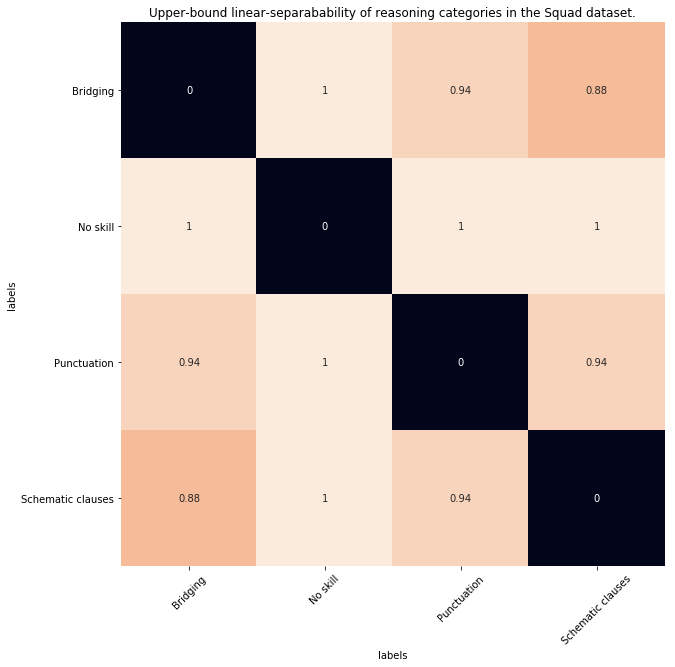

In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import cluster, metrics

plt.figure(figsize=(10, 10))

sss = sns.heatmap(accuracy_table_small, square=True,
            annot=True,
            cbar=False,
            xticklabels=True,
            yticklabels=True
            )

sss.set_xticklabels(unique_reasoning_types_small, rotation=45)
sss.set_yticklabels(unique_reasoning_types_small, rotation=0)
plt.xlabel('labels')
plt.ylabel('labels')
plt.title('Upper-bound linear-separabability of reasoning categories in the Squad dataset.')
plt.show()

{'Bridging',
 'Coreference',
 'Elaboration',
 'Ellipsis (implicit info)',
 'No skill',
 'Object Tracking',
 'Punctuation',
 'Schematic clauses',
 'Spatio-temporal'}

[[0.         1.95061728 1.53623188 2.         2.         1.66816143
  2.         1.56501182 1.74545455]
 [1.95061728 0.         1.68115942 2.         2.         1.90279465
  2.         1.71671388 1.67058824]
 [1.53623188 1.68115942 0.         2.         2.         1.32235294
  2.         1.37313433 1.32894737]
 [2.         2.         2.         0.         2.         1.81021898
  2.         1.71671388 2.        ]
 [2.         2.         2.         2.         0.         2.
  2.         1.85227273 2.        ]
 [1.66816143 1.90279465 1.32235294 1.81021898 2.         0.
  2.         1.68458781 1.75206612]
 [2.         2.         2.         2.         2.         2.
  0.         2.         2.        ]
 [1.56501182 1.71671388 1.37313433 1.71671388 1.85227273 1.68458781
  2.         0.         1.55633803]
 [1.74545455 1.67058824 1.32894737 2.         2.         1.75206612
  2.         1.55633803 0.        ]]


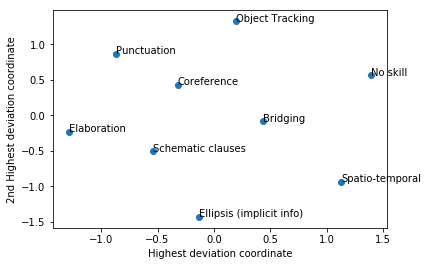

{'Bridging',
 'Coreference',
 'Elaboration',
 'Ellipsis (implicit info)',
 'No skill',
 'Object Tracking',
 'Punctuation',
 'Schematic clauses',
 'Spatio-temporal'}

In [42]:
# Enforce triangle inequality
from scipy.sparse.csgraph import shortest_path

distanceMatrix = accuracy_table # - np.ones(distanceMatrix.shape)
pathDistance=shortest_path(2*distanceMatrix)
print(pathDistance)

from sklearn.manifold import MDS
import matplotlib.pyplot as plt
mds=MDS(n_components=2,dissimilarity="precomputed", random_state=4)
emb=mds.fit_transform(pathDistance)
fig, ax = plt.subplots()
ax.scatter(emb[:,0],emb[:,1])
ax.set_xlabel("Highest deviation coordinate")
ax.set_ylabel("2nd Highest deviation coordinate")
for i, txt in enumerate(unique_reasoning_types):
    ax.annotate(txt, (emb[i,0],emb[i,1]))
plt.show()
unique_reasoning_types

In [17]:
# a single classifier 
from sklearn.neural_network import MLPClassifier

# training a single classifier on the data 
from sklearn.linear_model import LogisticRegression
import numpy 

ss = len(unique_reasoning_types)
accuracy_table = np.zeros(shape=(ss, ss)) 


from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
multirc_reasoning_types_binarized = mlb.fit_transform(multirc_reasoning_types)
mlb.classes_

# print(len(multirc_reasoning_types))

mlp = MLPClassifier(hidden_layer_sizes=(), alpha=10)
mlp.fit(mat,multirc_reasoning_types_binarized)


/Users/daniel/.virtualenvs/bidaf_allennlp/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=10, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [18]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score    
    
predictions = mlp.predict(mat)

for i, class_ in enumerate(mlb.classes_): 
    predictions_per_class = [x[i] for x in predictions]
    gold_per_class = [x[i] for x in multirc_reasoning_types_binarized]
    f1_ = f1_score(gold_per_class, predictions_per_class) 
    size_ = sum(gold_per_class)
    print(f"Class: {class_} \t count: {size_} \t F1: {f1_}")
    

Class: Bridging 	 count: 41 	 F1: 1.0
Class: Coreference 	 count: 12 	 F1: 1.0
Class: Elaboration 	 count: 13 	 F1: 1.0
Class: Ellipsis (implicit info) 	 count: 3 	 F1: 1.0
Class: No skill 	 count: 27 	 F1: 1.0
Class: Object Tracking 	 count: 3 	 F1: 1.0
Class: Punctuation 	 count: 23 	 F1: 1.0
Class: Schematic clauses 	 count: 27 	 F1: 1.0
Class: Spatio-temporal 	 count: 2 	 F1: 1.0


In [26]:
# train a single classifier, which gets two input vectors and tell us whether the they share a class or not. 
import random 

# first, create the input data. 
assert len(mat) == len(multirc_reasoning_types)

input_mat = []
output_vals = []

def are_disjoint(a, b): 
    return set(a).isdisjoint(b)

for i, x1 in enumerate(mat): 
    print(f"adding instances: {100.0 * i / len(mat)}")
    for j, x2 in enumerate(mat): 
        if i == j: 
            continue 
            
        if are_disjoint(multirc_reasoning_types[i], multirc_reasoning_types[j]): 
            output_vals.append(1)
            input_mat.append(mat[i] + mat[j])
        else:
            if random.uniform(0, 1) >= 0.75: 
                continue 
            input_mat.append(mat[i] + mat[j])
            output_vals.append(0)
            

adding instances: 0.0
adding instances: 1.0416666666666667
adding instances: 2.0833333333333335
adding instances: 3.125
adding instances: 4.166666666666667
adding instances: 5.208333333333333
adding instances: 6.25
adding instances: 7.291666666666667
adding instances: 8.333333333333334
adding instances: 9.375
adding instances: 10.416666666666666
adding instances: 11.458333333333334
adding instances: 12.5
adding instances: 13.541666666666666
adding instances: 14.583333333333334
adding instances: 15.625
adding instances: 16.666666666666668
adding instances: 17.708333333333332
adding instances: 18.75
adding instances: 19.791666666666668
adding instances: 20.833333333333332
adding instances: 21.875
adding instances: 22.916666666666668
adding instances: 23.958333333333332
adding instances: 25.0
adding instances: 26.041666666666668
adding instances: 27.083333333333332
adding instances: 28.125
adding instances: 29.166666666666668
adding instances: 30.208333333333332
adding instances: 31.25
ad

In [27]:
# make sure the dataset selection is balanced 
sum(output_vals), len(output_vals)

(5766, 8284)

In [28]:
# train the classifier 
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(input_mat, output_vals) 

sum(output_vals)

5766

In [29]:
ss = len(unique_types111)
separation_table = np.zeros(shape=(ss, ss)) 
unique_types111_list = list(unique_types111)
for ind1, type1 in enumerate(unique_types111_list): 
    for ind2, type2 in enumerate(unique_types111_list):
        
        # we want different types 
        if type1 == type2: #  or ind2 <= ind1  
            continue 
        print("type1: ", type1, " type2: ", type2)
        
        # loop through instances and select the points that have one of the two labels. 

        y_true = []
        input_vecs = []
        for i, x in enumerate(multirc_reasoning_types): 
            for j, y in enumerate(multirc_reasoning_types): 
                if type1 in x and type2 in y: 
                    input_vecs.append(mat[i] + mat[j]) 
                    if are_disjoint(x, y): 
                        y_true.append(1)
                    else: 
                        y_true.append(0)
                
        y_pred = list(clf.predict(input_vecs))
        
        assert(len(y_pred) == len(y_true))
#         print(y_pred)
#         print(y_true)
    
        from sklearn.metrics import f1_score
        separation_table[ind1][ind2] = f1_score(y_true, y_pred)
        print(separation_table[ind1][ind2])
    

type1:  Punctuation  type2:  Bridging
0.7808564231738034
type1:  Punctuation  type2:  Elaboration
0.8846153846153847
type1:  Punctuation  type2:  Object  Tracking
0.6666666666666666
type1:  Punctuation  type2:  No skill
0.9357326478149101
type1:  Punctuation  type2:  Schematic clauses
0.7908902691511386
type1:  Punctuation  type2:  Spatio-temporal
0.9367088607594937
type1:  Punctuation  type2:  Ellipsis (implicit info)
0.9090909090909091
type1:  Punctuation  type2:  Coreference
0.7074829931972789
type1:  Bridging  type2:  Punctuation
0.7808564231738034
type1:  Bridging  type2:  Elaboration
0.9103214890016921
type1:  Bridging  type2:  Object  Tracking
0.7160493827160493
type1:  Bridging  type2:  No skill
0.9649368863955119
type1:  Bridging  type2:  Schematic clauses
0.8896247240618101
type1:  Bridging  type2:  Spatio-temporal
0.953020134228188
type1:  Bridging  type2:  Ellipsis (implicit info)
0.7073170731707317
type1:  Bridging  type2:  Coreference
0.7045454545454547
type1:  Elaboratio

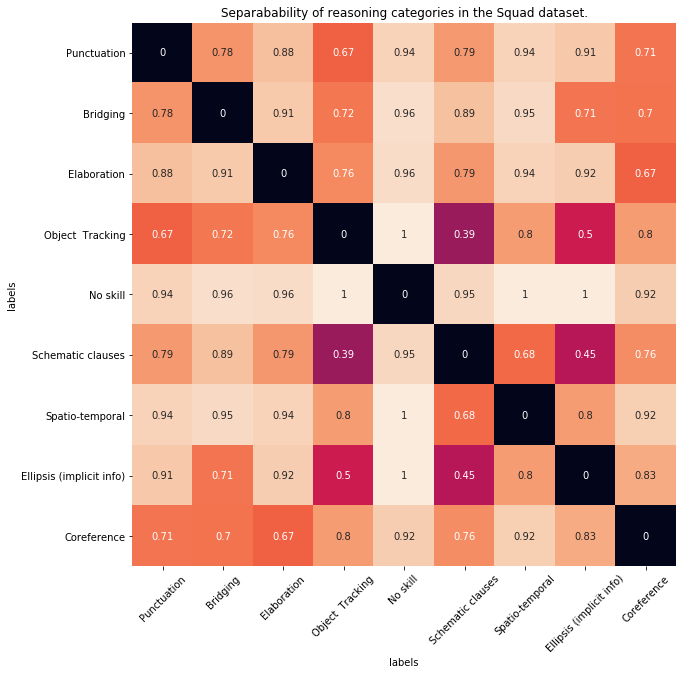

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import cluster, metrics

plt.figure(figsize=(10, 10))
sss = sns.heatmap(separation_table, square=True,
            annot=True,
            cbar=False,
            xticklabels=True,
            yticklabels=True
            )

sss.set_xticklabels(unique_types111_list, rotation=45)
sss.set_yticklabels(unique_types111_list, rotation=0)
plt.xlabel('labels')
plt.ylabel('labels')
plt.title('Separabability of reasoning categories, based on BiDAF representations, in the Squad dataset.')
plt.show()

In [31]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in separation_table]))
print(unique_types111_list)

0.0	0.7808564231738034	0.8846153846153847	0.6666666666666666	0.9357326478149101	0.7908902691511386	0.9367088607594937	0.9090909090909091	0.7074829931972789
0.7808564231738034	0.0	0.9103214890016921	0.7160493827160493	0.9649368863955119	0.8896247240618101	0.953020134228188	0.7073170731707317	0.7045454545454547
0.8846153846153847	0.9103214890016921	0.0	0.7555555555555554	0.9600000000000001	0.7874396135265701	0.9361702127659575	0.9199999999999999	0.6666666666666666
0.6666666666666666	0.7160493827160493	0.7555555555555554	0.0	1.0	0.3859649122807018	0.8	0.5	0.8
0.9357326478149101	0.9649368863955119	0.9600000000000001	1.0	0.0	0.9457700650759219	1.0	1.0	0.92
0.7908902691511386	0.8896247240618101	0.7874396135265701	0.3859649122807018	0.9457700650759219	0.0	0.6842105263157895	0.4516129032258065	0.7644444444444445
0.9367088607594937	0.953020134228188	0.9361702127659575	0.8	1.0	0.6842105263157895	0.0	0.8	0.923076923076923
0.9090909090909091	0.7073170731707317	0.9199999999999999	0.5	1.0	0.45161290

[[0.         0.78085642 0.88461538 0.66666667 0.93573265 0.79089027
  0.93670886 0.90909091 0.70748299]
 [0.78085642 0.         0.91032149 0.71604938 0.96493689 0.88962472
  0.95302013 0.70731707 0.70454545]
 [0.88461538 0.91032149 0.         0.75555556 0.96       0.78743961
  0.93617021 0.92       0.66666667]
 [0.66666667 0.71604938 0.75555556 0.         1.         0.38596491
  0.8        0.5        0.8       ]
 [0.93573265 0.96493689 0.96       1.         0.         0.94577007
  1.         1.         0.92      ]
 [0.79089027 0.88962472 0.78743961 0.38596491 0.94577007 0.
  0.68421053 0.4516129  0.76444444]
 [0.93670886 0.95302013 0.93617021 0.8        1.         0.68421053
  0.         0.8        0.92307692]
 [0.90909091 0.70731707 0.92       0.5        1.         0.4516129
  0.8        0.         0.83333333]
 [0.70748299 0.70454545 0.66666667 0.8        0.92       0.76444444
  0.92307692 0.83333333 0.        ]]


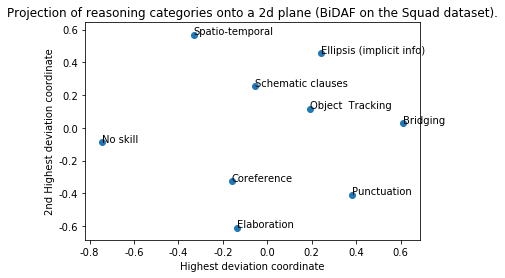

In [33]:
from scipy.sparse.csgraph import shortest_path

# dissimalrity = accuracy_table
#distanceMatrix = dissimalrity+0.5*np.eye(dissimalrity.shape[0], dissimalrity.shape[1])
# distanceMatrix = accuracy_table # - np.ones(distanceMatrix.shape)
pathDistance=shortest_path(separation_table)
print(pathDistance)

from sklearn.manifold import MDS
import matplotlib.pyplot as plt
mds=MDS(n_components=2,dissimilarity="precomputed", random_state=4)
emb=mds.fit_transform(pathDistance)
fig, ax = plt.subplots()
ax.scatter(emb[:,0],emb[:,1])
ax.set_xlabel("Highest deviation coordinate")
ax.set_ylabel("2nd Highest deviation coordinate")
for i, txt in enumerate(unique_types111):
    ax.annotate(txt, (emb[i,0],emb[i,1]))
plt.title('Projection of reasoning categories onto a 2d plane (BiDAF on the Squad dataset).')
plt.show()